In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = nn.Dropout(p=self.droprate)(out)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class CNN(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=10, dropRate=0.0):
        super(CNN, self).__init__()
        
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)
        
        # 1st block
        self.block1 = self._make_layer(block, nChannels[0], nChannels[1], n, stride=1, dropRate=dropRate)
        
        # 2nd block
        self.block2 = self._make_layer(block, nChannels[1], nChannels[2], n, stride=2, dropRate=dropRate)
        
        # 3rd block
        self.block3 = self._make_layer(block, nChannels[2], nChannels[3], n, stride=2, dropRate=dropRate)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
        
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate=0.0):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = nn.AvgPool2d(8)(out)
        out = out.view(-1, self.nChannels)
        return self.fc(out)
    
    def train_model(self, train_loader, num_epochs=10, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.to(device)
        
        warm_up_epochs = 5
        warm_up_lr = 0.01
        lr_step = (0.1 - warm_up_lr) / warm_up_epochs
        
        def lr_schedule(epoch):
            if epoch < warm_up_epochs:
                return warm_up_lr + lr_step * epoch
            elif epoch < 60:
                return 0.1
            elif epoch < 120:
                return 0.02
            elif epoch < 160:
                return 0.004
            else:
                return 0.0008
        
        scheduler = optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lr_schedule)
        
        total_training_time = 0

        for epoch in range(num_epochs):
            start_time = time.time()
            self.train()
            total_loss = 0
            correct_predictions = 0
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                self.optimizer.zero_grad()
                outputs = self(data)
                loss = self.criterion(outputs, target)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == target).sum().item()
            average_loss = total_loss / len(train_loader)
            classification_error = 100 * (1 - correct_predictions / len(train_loader.dataset))
            epoch_time = time.time() - start_time
            total_training_time += epoch_time
            scheduler.step()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Classification Error: {classification_error:.2f}%, Time: {epoch_time:.2f} seconds")
        
        print(f"Total Training Time: {total_training_time:.2f} seconds")
    
    def evaluate(self, test_loader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = self(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f"Точность сети на тестовых изображениях: {accuracy:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Тренировочные данные:


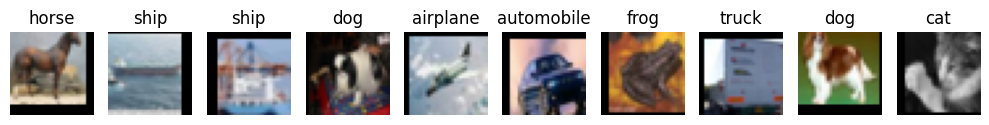

Тестовые данные:


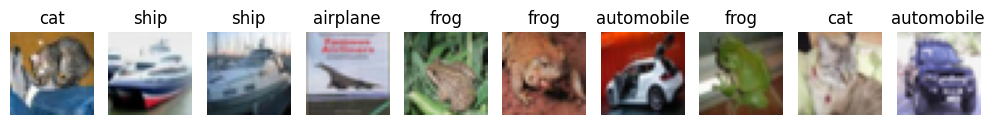

Размерность x_train: (50000, 32, 32, 3)
Размерность y_train: 50000
Размерность x_test: (10000, 32, 32, 3)
Размерность y_test: 10000


In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Загрузка данных
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Визуализация данных
def visualize_data(loader, title):
    print(f"{title}:")
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 10, figsize=(10, 5))
    for ax, image, label in zip(axes, images, labels):
        image = image.permute(1, 2, 0)
        image = image * torch.tensor((0.2023, 0.1994, 0.2010)) + torch.tensor((0.4914, 0.4822, 0.4465))
        image = image.clamp(0, 1)
        ax.set_title(classes[label])
        ax.imshow(image)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_data(train_loader, "Тренировочные данные")
visualize_data(test_loader, "Тестовые данные")

# Проверка размерностей
print(f"Размерность x_train: {train_dataset.data.shape}")
print(f"Размерность y_train: {len(train_dataset.targets)}")
print(f"Размерность x_test: {test_dataset.data.shape}")
print(f"Размерность y_test: {len(test_dataset.targets)}")

Модель "CNN":
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]          23,040
       BatchNorm2d-5          [-1, 160, 32, 32]             320
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32]         230,400
            Conv2d-8          [-1, 160, 32, 32]           2,560
        BasicBlock-9          [-1, 160, 32, 32]               0
      BatchNorm2d-10          [-1, 160, 32, 32]             320
             ReLU-11          [-1, 160, 32, 32]               0
           Conv2d-12          [-1, 160, 32, 32]         230,400
      BatchNorm2d-13          [-1, 160, 32, 32]             320
             ReLU-14     

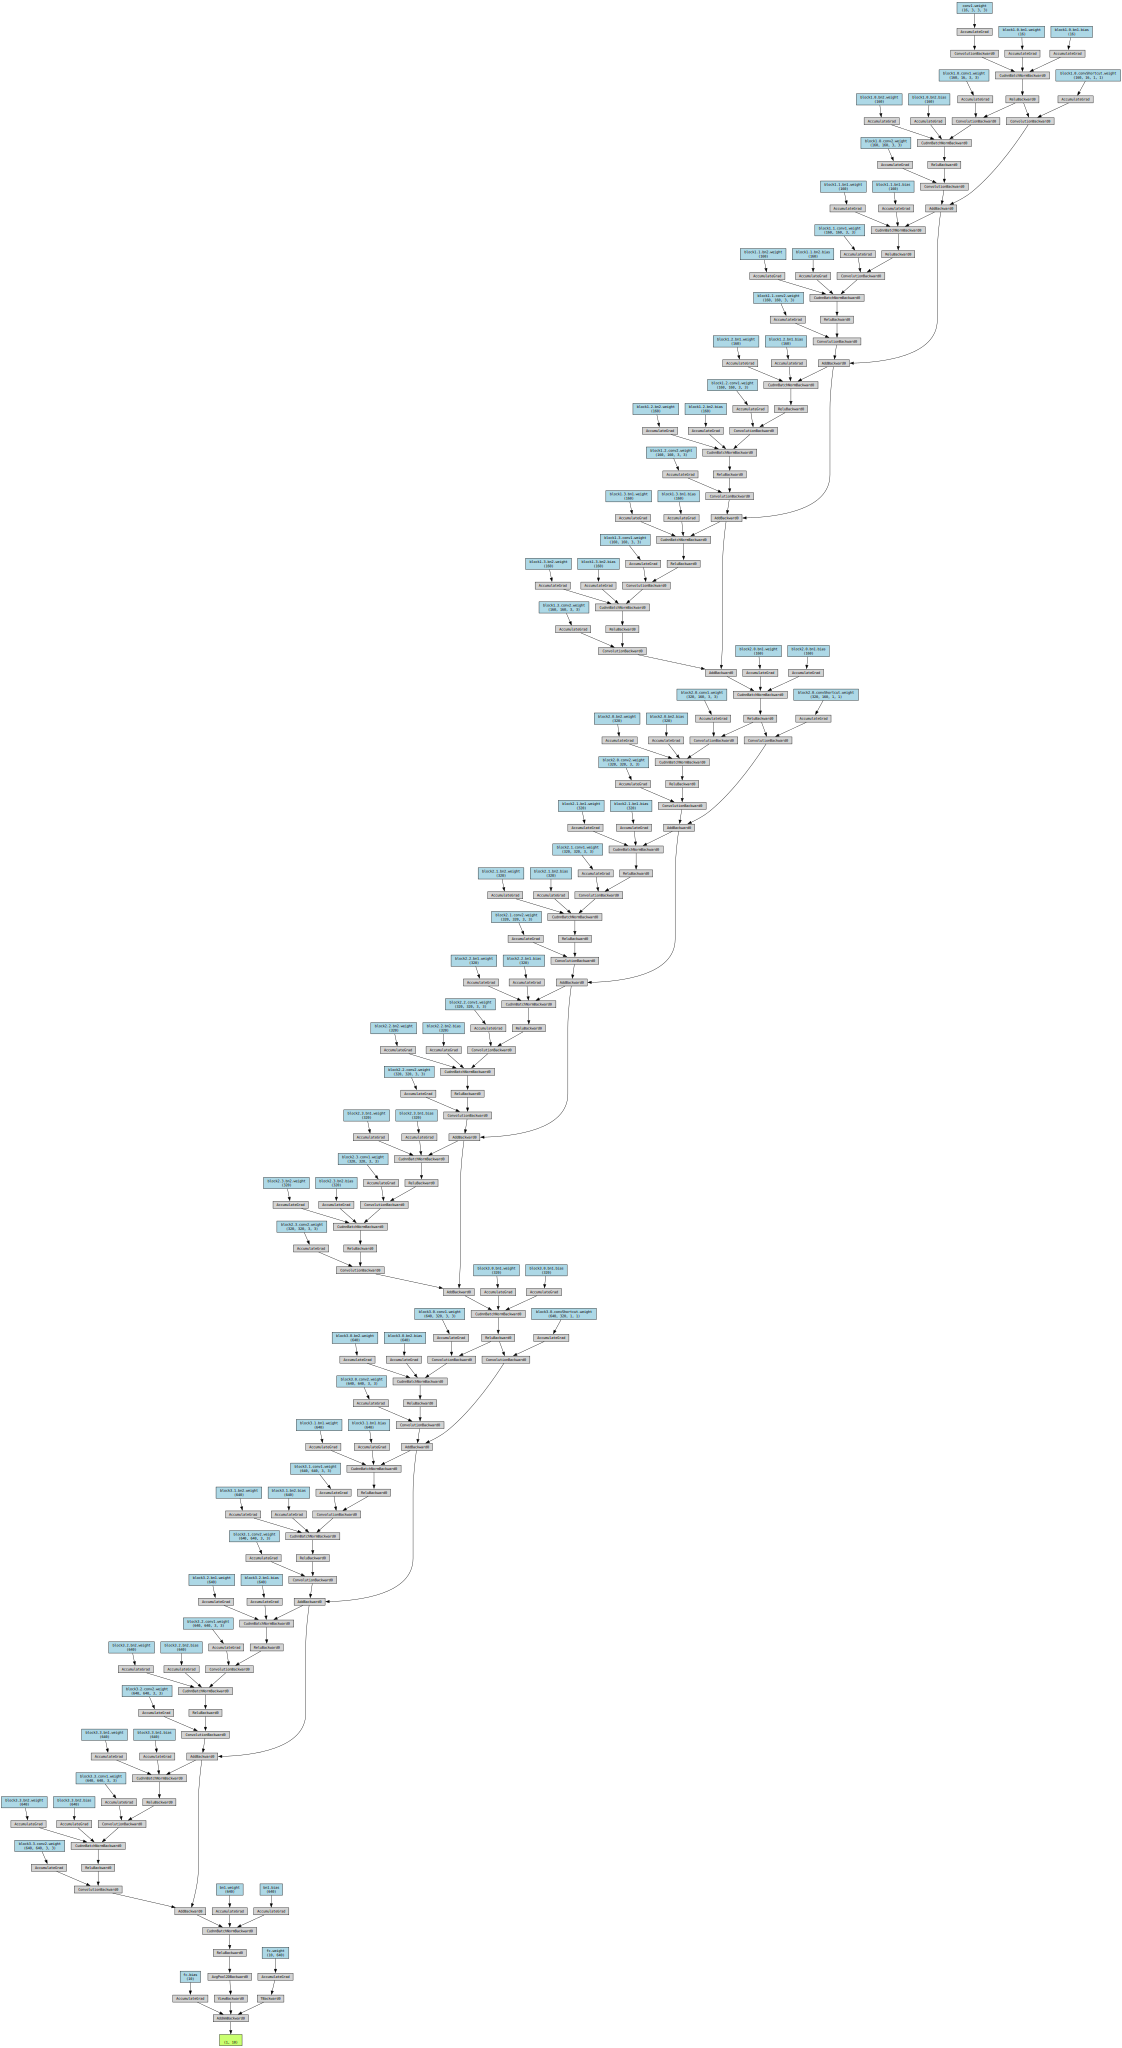

In [4]:
# Настройка параметров
batch_size = 128

model = CNN(num_classes=len(classes)).to(device)

# Информация об архитектуре и визуализация сети
print("Модель \"CNN\":")
summary(model, input_size=(3, 32, 32))

print("Визуализация модели:")
display(make_dot(model(torch.randn(1, 3, 32, 32).to(device)), params=dict(model.named_parameters())))

In [5]:
# Обучение сети
model.train_model(train_loader, num_epochs=200)
# Тестирование сети
model.evaluate(test_loader)

Epoch [1/200], Loss: 1.6575, Classification Error: 60.68%, Time: 110.36 seconds
Epoch [2/200], Loss: 1.1163, Classification Error: 40.19%, Time: 110.45 seconds
Epoch [3/200], Loss: 0.8031, Classification Error: 28.01%, Time: 110.70 seconds
Epoch [4/200], Loss: 0.6395, Classification Error: 22.06%, Time: 110.71 seconds
Epoch [5/200], Loss: 0.5397, Classification Error: 18.55%, Time: 110.73 seconds
Epoch [6/200], Loss: 0.4766, Classification Error: 16.32%, Time: 110.75 seconds
Epoch [7/200], Loss: 0.4050, Classification Error: 13.87%, Time: 110.77 seconds
Epoch [8/200], Loss: 0.3507, Classification Error: 12.07%, Time: 110.77 seconds
Epoch [9/200], Loss: 0.3158, Classification Error: 10.86%, Time: 110.79 seconds
Epoch [10/200], Loss: 0.2822, Classification Error: 9.70%, Time: 110.79 seconds
Epoch [11/200], Loss: 0.2617, Classification Error: 9.05%, Time: 111.27 seconds
Epoch [12/200], Loss: 0.2369, Classification Error: 8.22%, Time: 113.21 seconds
Epoch [13/200], Loss: 0.2171, Classifica